# Code to compare two states vs regulation - with counts, random pairs and twin pairs


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
from pylab import figure, subplot, text, xlim, ylim, title, plot, axvline, ylabel, xlabel, legend
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

In [2]:
import os
os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = False

In [3]:
orig_params = pylab.rcParams.copy()
params = {'legend.fontsize': '20',
          'figure.figsize': (15, 10),
          'axes.labelsize': '20',
          'axes.titlesize':'25',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20',
          'axes.linewidth': '0.5',
          'pdf.fonttype': '42'}
pylab.rcParams.update(params)
# pylab.style.use('seaborn-white')

In [8]:
#PARAM VALS FOR THIS RUN
sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/two_way_regulation/test/samples_replicates_with_regulation_0.csv'
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/self_regulation/A_B_Bloops_1.csv'
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/samples_replicates_with_regulation_median_0.csv'
num_sampling_times = 24
num_cells = 20e3

updated_df = pd.read_csv(sim_file_use)
updated_df['unspliced_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['unspliced_labeled_Target']
updated_df['unspliced_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['unspliced_labeled_TF']

updated_df['labeled_Target'] = updated_df['unspliced_labeled_Target']+updated_df['spliced_labeled_Target']
updated_df['labeled_TF'] = updated_df['unspliced_labeled_TF']+updated_df['spliced_labeled_TF']

updated_df['unlabeled_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['spliced_unlabeled_Target']
updated_df['unlabeled_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['spliced_unlabeled_TF']

updated_df

,Unnamed: 0,TF_is_bursting,Target_is_bursting,TF_protein_1K,Target_protein_1K,spliced_labeled_Target,spliced_labeled_TF,spliced_unlabeled_Target,spliced_unlabeled_TF,unspliced_labeled_Target,...,k_on_TF_adjusted,total_TF_mRNA,total_Target_mRNA,sampling_time,replicate,unspliced_TF,labeled_Target,labeled_TF,unlabeled_Target,unlabeled_TF
0,0,False,True,557.150793,1101.385034,0.000000,0.0,487.727262,1.750000e+02,0.0,...,2.818288e+00,1.750000e+02,498.132514,0,0,1.017441e-05,0.000000,0.0,495.132514,1.750000e+02
1,1,False,False,447.806669,658.027100,0.000000,0.0,285.116652,1.450133e+02,0.0,...,1.733055e+00,1.450133e+02,285.116652,0,0,1.301380e-07,0.000000,0.0,285.116652,1.450133e+02
2,2,False,False,6.642168,10.923554,0.000000,0.0,0.000000,1.429480e-319,0.0,...,7.977228e-04,1.429480e-319,0.000000,0,0,0.000000e+00,0.000000,0.0,0.000000,1.429480e-319
3,3,False,False,500.120496,913.507695,0.000000,0.0,501.467674,1.555133e+02,0.0,...,2.434414e+00,1.555309e+02,501.533333,0,0,1.756873e-02,0.000000,0.0,501.533333,1.555309e+02
4,4,True,False,543.633755,1054.798003,0.000000,0.0,315.533333,2.629021e+02,0.0,...,2.732512e+00,2.639021e+02,317.533333,0,0,2.954055e-13,0.000000,0.0,315.533333,2.629021e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,True,False,506.507710,1024.900446,0.333333,0.0,553.472026,2.297084e+02,0.0,...,2.673521e+00,2.360854e+02,553.805359,1440,1,6.377079e+00,0.333333,0.0,553.472026,2.360854e+02
999996,999996,False,False,26.681020,43.956969,0.000000,0.0,0.000000,3.920000e+00,0.0,...,1.286495e-02,3.920000e+00,0.000000,1440,1,4.214380e-321,0.000000,0.0,0.000000,3.920000e+00
999997,999997,True,False,557.791059,832.276616,0.333333,0.0,451.696013,2.435942e+02,0.0,...,2.233828e+00,2.500574e+02,459.435002,1440,1,6.463259e+00,0.333333,0.0,459.101669,2.500574e+02
999998,999998,False,False,0.408773,0.364471,0.000000,0.0,0.000000,0.000000e+00,0.0,...,8.871023e-07,0.000000e+00,0.000000,1440,1,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00


In [7]:
updated_df.columns

Index(['Unnamed: 0', 'TF_is_bursting', 'Target_is_bursting', 'TF_protein_1K',
       'spliced_labeled_Target', 'spliced_labeled_TF',
       'spliced_unlabeled_Target', 'spliced_unlabeled_TF',
       'unspliced_labeled_Target', 'unspliced_labeled_TF',
       'unspliced_unlabeled_Target', 'unspliced_unlabeled_TF',
       'unspliced_Target', 'mRNA_ever_produced_Target',
       'mRNA_ever_produced_TF', 'protein_ever_produced_TF',
       'k_on_Target_adjusted', 'total_TF_mRNA', 'total_Target_mRNA',
       'sampling_time', 'replicate', 'unspliced_TF', 'labeled_Target',
       'labeled_TF', 'unlabeled_Target', 'unlabeled_TF'],
      dtype='object')

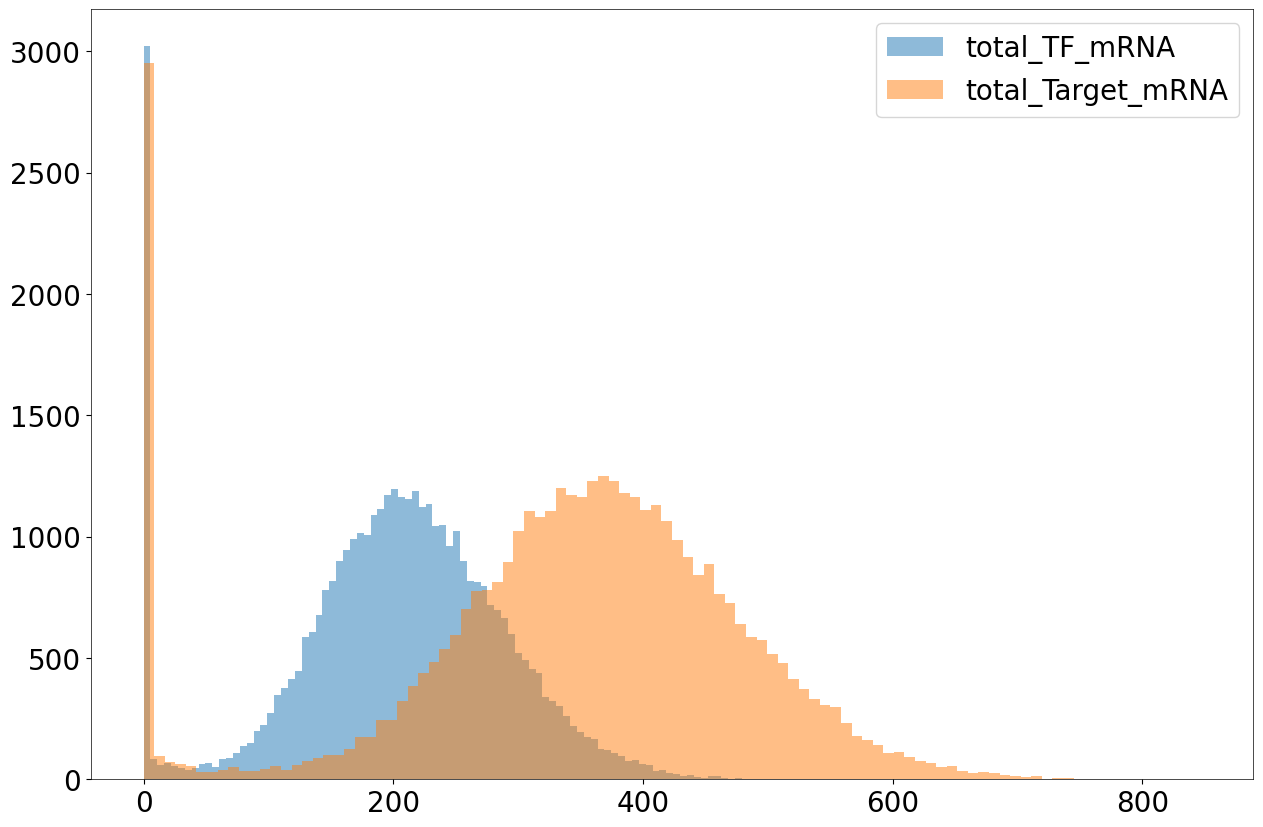

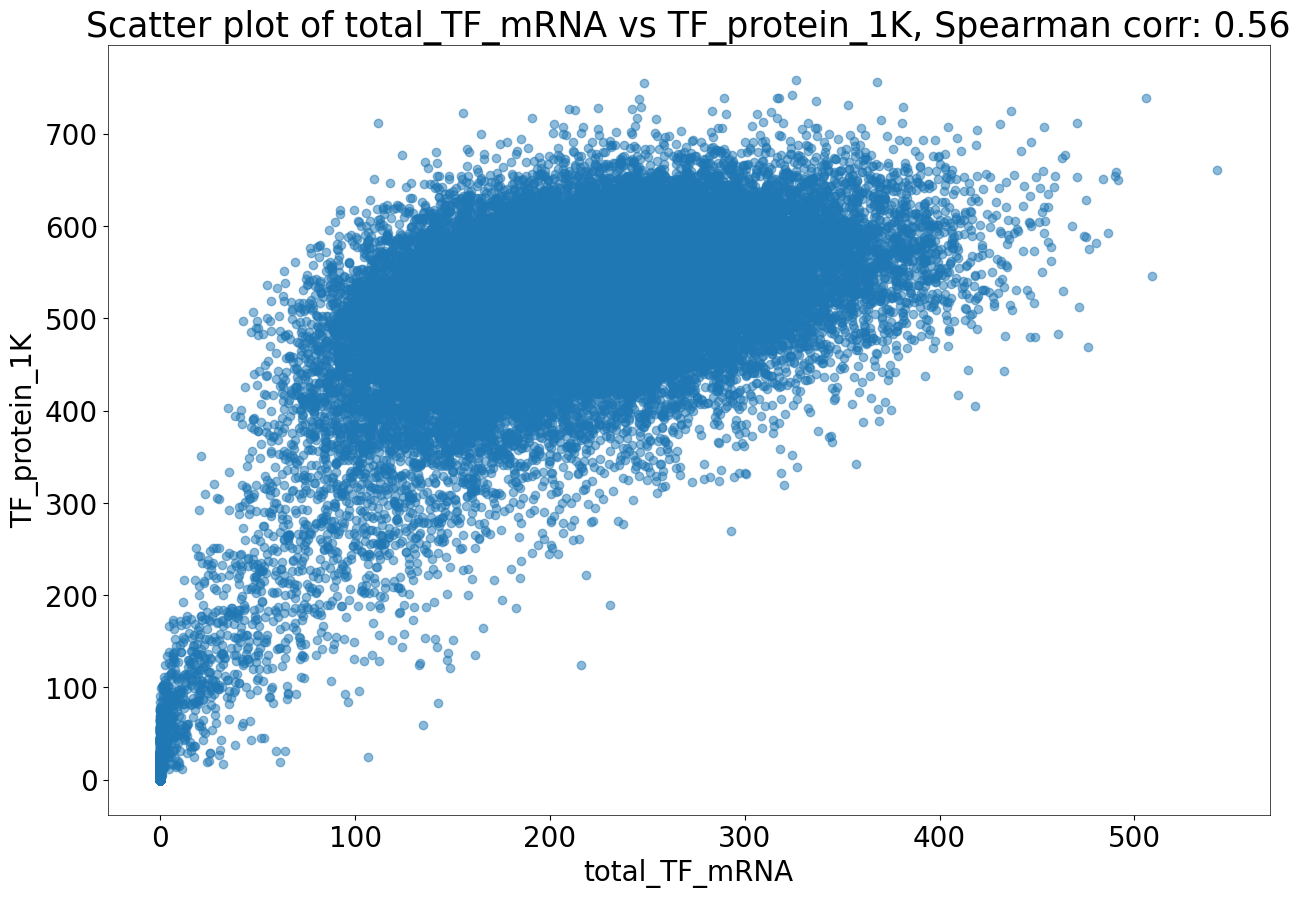

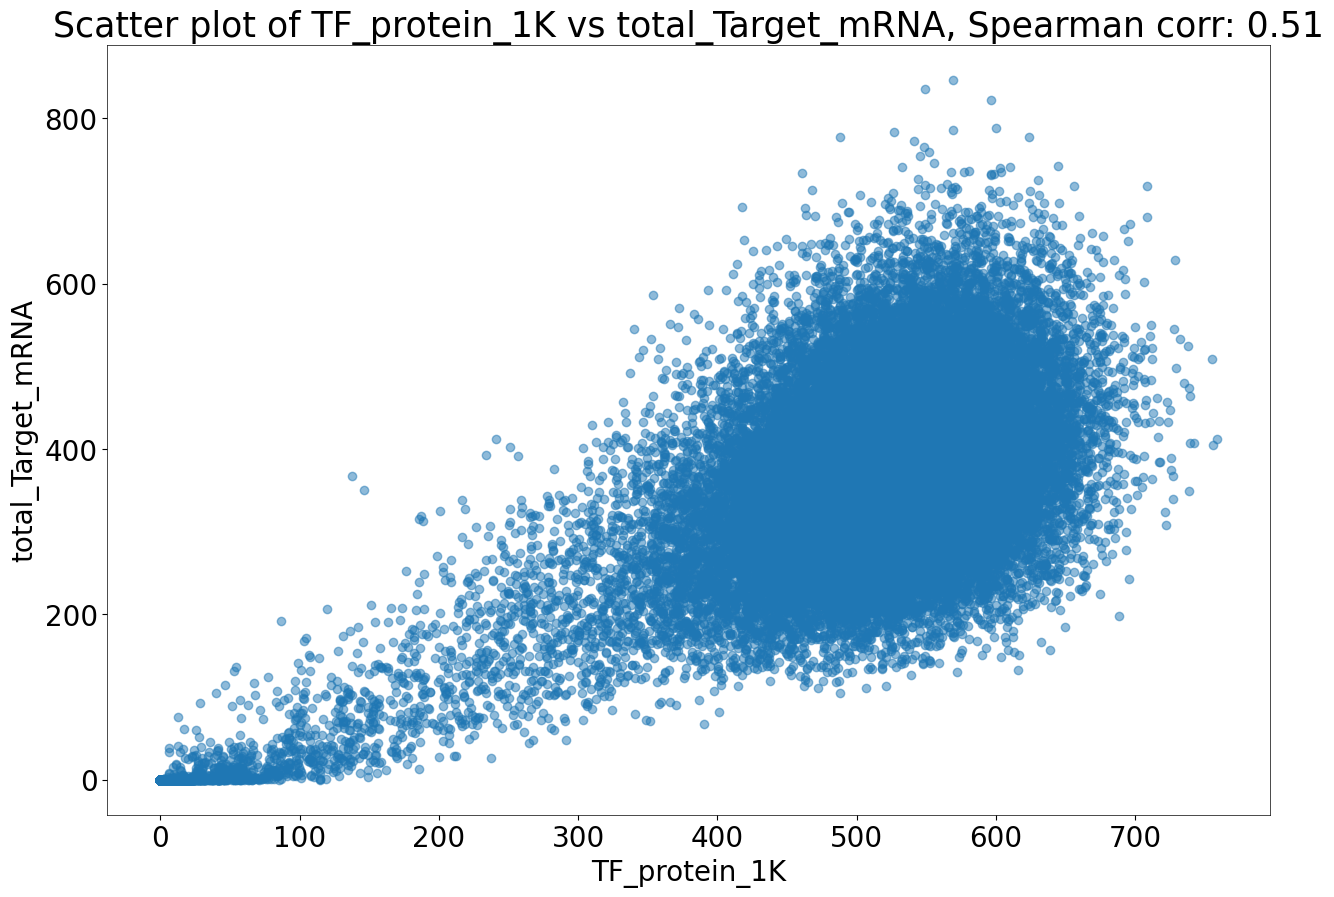

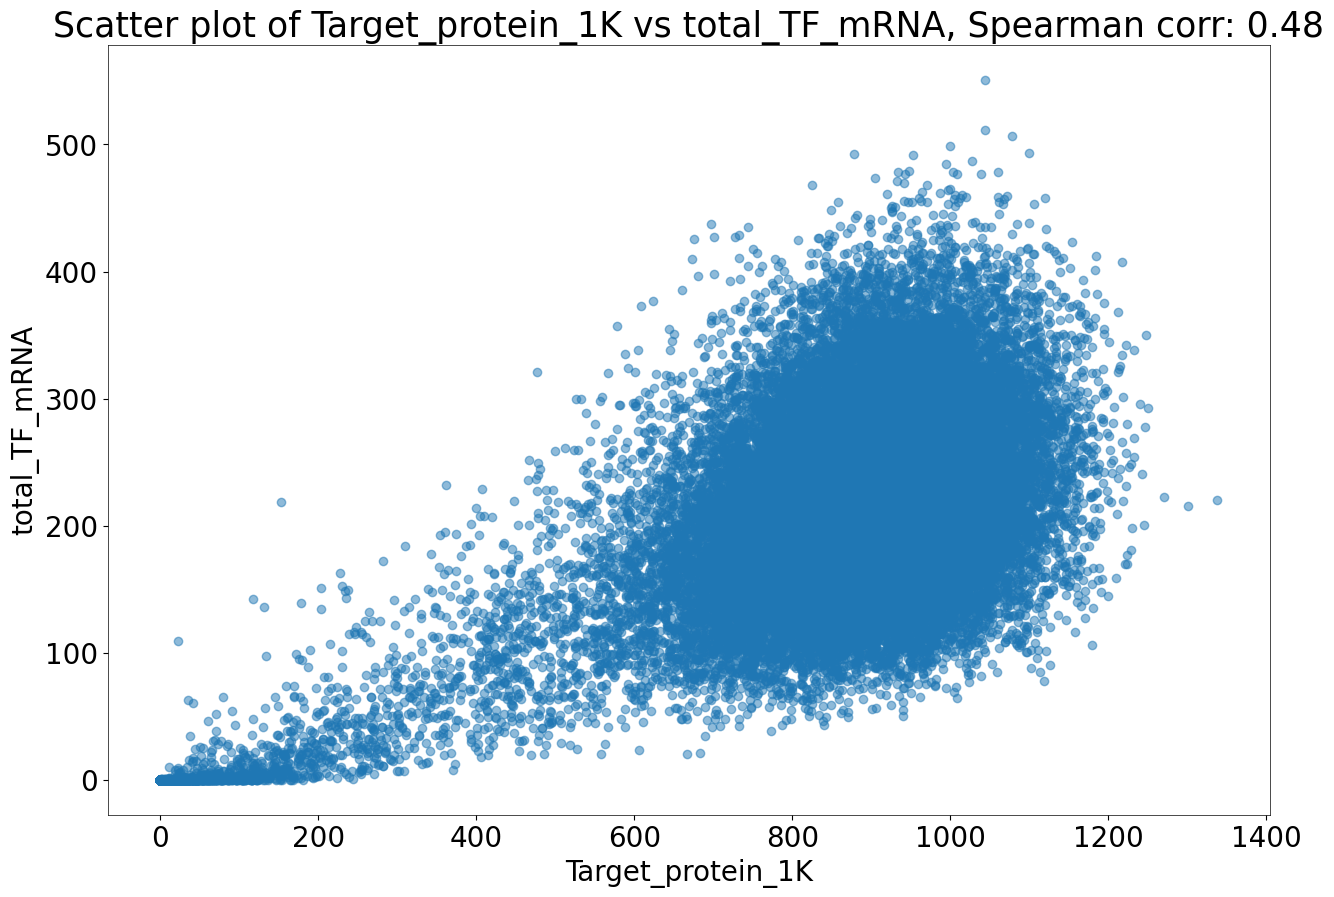

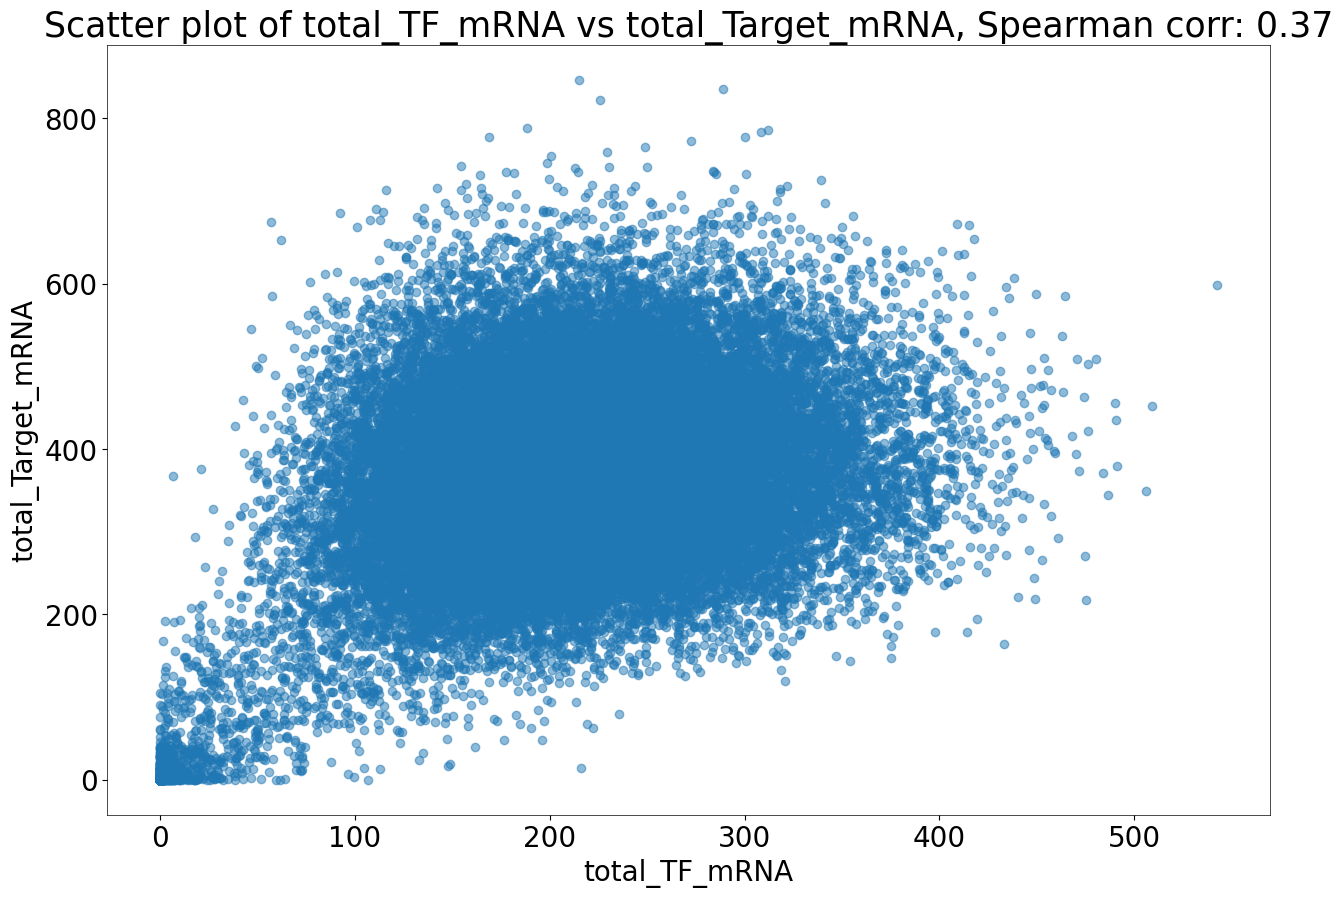

In [9]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

#Select the top and bottom 10 percentile of the TF mRNA
singleTime_df = singleTime_df.sort_values(by='total_TF_mRNA')
top_10 = singleTime_df.tail(int(len(singleTime_df)*0.1))
bottom_10 = singleTime_df.head(int(len(singleTime_df)*0.1))

#Combined top and bottom 10 percentile
combined_10 =  singleTime_df #pd.concat([top_10, bottom_10])

plt.hist((combined_10['total_TF_mRNA']), bins=100, alpha=0.5, label='total_TF_mRNA')
plt.hist(combined_10['total_Target_mRNA'], bins=100, alpha=0.5, label='total_Target_mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter((combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']), combined_10['TF_protein_1K'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], (combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']))
plt.ylabel('TF_protein_1K')
plt.xlabel('total_TF_mRNA')
plt.title('Scatter plot of total_TF_mRNA vs TF_protein_1K, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'])
plt.xlabel('TF_protein_1K')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of TF_protein_1K vs total_Target_mRNA, Spearman corr: {corr.correlation:.2f}')
plt.show()

plt.scatter(combined_10['Target_protein_1K'], combined_10['total_TF_mRNA'], alpha=0.5)
corr = spearmanr(combined_10['Target_protein_1K'], combined_10['total_TF_mRNA'])
plt.xlabel('Target_protein_1K')
plt.ylabel('total_TF_mRNA')
plt.title(f'Scatter plot of Target_protein_1K vs total_TF_mRNA, Spearman corr: {corr.correlation:.2f}')
plt.show()

plt.scatter((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'], alpha=0.5)
corr = spearmanr((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'])
plt.xlabel('total_TF_mRNA')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of total_TF_mRNA vs total_Target_mRNA, Spearman corr: {corr[0]:.2f}')
plt.show()

Replicate 0 at time 1 shape: (20000, 29)
Replicate 1 at time 2 shape: (20000, 29)
Spearman correlation: 6.06e-01


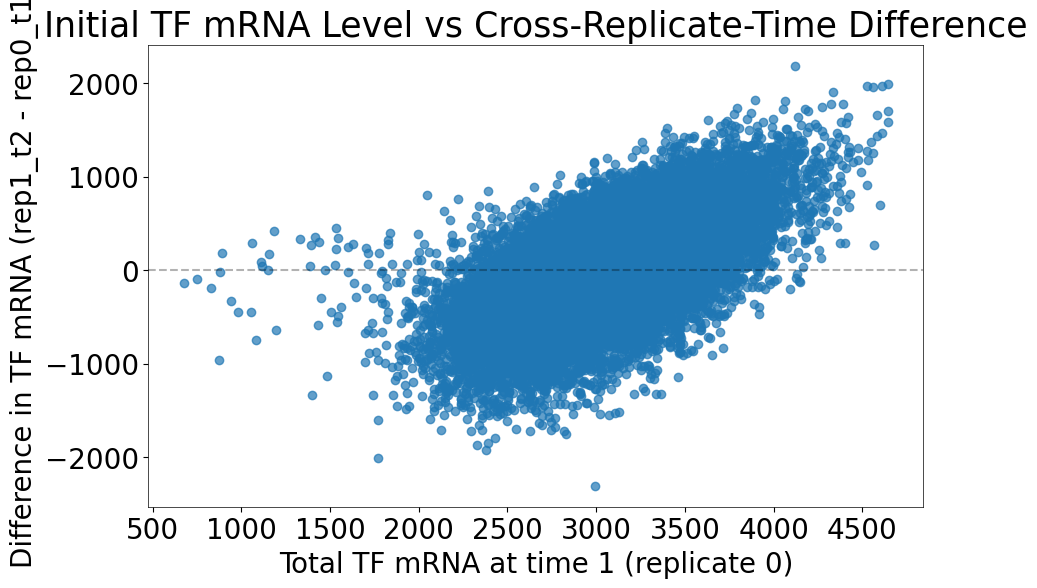

In [19]:
t1_data = updated_df[updated_df['sampling_time'] == 300]
t2_data = updated_df[updated_df['sampling_time'] == 600]

rep0_t1 = t1_data[t1_data['replicate'] == 0].reset_index(drop=True)
rep0_t2 = t2_data[t2_data['replicate'] == 0].reset_index(drop=True)
rep1_t1 = t1_data[t1_data['replicate'] == 1].reset_index(drop=True)
rep1_t2 = t2_data[t2_data['replicate'] == 1].reset_index(drop=True)
print("Replicate 0 at time 1 shape:", rep0_t1.shape)
print("Replicate 1 at time 2 shape:", rep1_t2.shape)

# Plot: Initial level (rep0_t1) vs difference between replicates at second time point
plt.figure(figsize=(10, 6))
plt.scatter(rep0_t1['total_TF_mRNA'], 
           rep0_t1['total_TF_mRNA'] - rep1_t2['total_TF_mRNA'], alpha=0.7)
corr = spearmanr(rep0_t1['total_TF_mRNA'], rep0_t1['total_TF_mRNA'] - rep1_t2['total_TF_mRNA'])
print(f"Spearman correlation: {corr.correlation:.2e}")
plt.xlabel('Total TF mRNA at time 1 (replicate 0)')
plt.ylabel('Difference in TF mRNA (rep1_t2 - rep0_t1)')
plt.title('Initial TF mRNA Level vs Cross-Replicate-Time Difference')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.show()

Replicate 0 at time 1 shape: (20000, 29)
Replicate 1 at time 2 shape: (20000, 29)
Spearman correlation: 6.17e-01


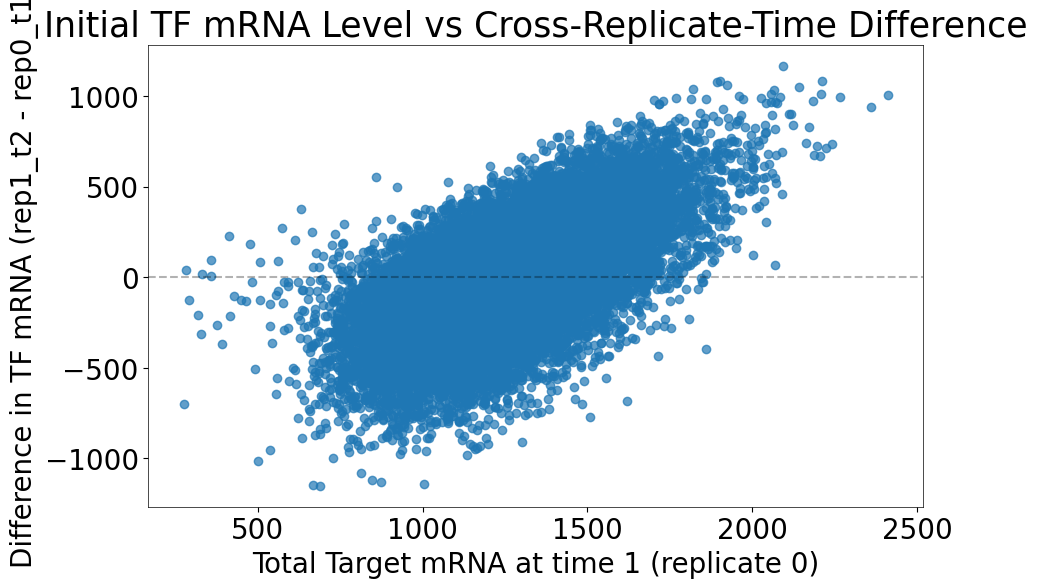

In [20]:
t1_data = updated_df[updated_df['sampling_time'] == 300]
t2_data = updated_df[updated_df['sampling_time'] == 600]

rep0_t1 = t1_data[t1_data['replicate'] == 0].reset_index(drop=True)
rep0_t2 = t2_data[t2_data['replicate'] == 0].reset_index(drop=True)
rep1_t1 = t1_data[t1_data['replicate'] == 1].reset_index(drop=True)
rep1_t2 = t2_data[t2_data['replicate'] == 1].reset_index(drop=True)
print("Replicate 0 at time 1 shape:", rep0_t1.shape)
print("Replicate 1 at time 2 shape:", rep1_t2.shape)

# Plot: Initial level (rep0_t1) vs difference between replicates at second time point
plt.figure(figsize=(10, 6))
plt.scatter(rep0_t1['total_Target_mRNA'], 
           rep0_t1['total_Target_mRNA'] - rep1_t2['total_Target_mRNA'], alpha=0.7)
corr = spearmanr(rep0_t1['total_Target_mRNA'], rep0_t1['total_Target_mRNA'] - rep1_t2['total_Target_mRNA'])
print(f"Spearman correlation: {corr.correlation:.2e}")
plt.xlabel('Total Target mRNA at time 1 (replicate 0)')
plt.ylabel('Difference in TF mRNA (rep1_t2 - rep0_t1)')
plt.title('Initial TF mRNA Level vs Cross-Replicate-Time Difference')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.show()

In [14]:
top_10_rep0_t1

,Unnamed: 0,TF_is_bursting,Target_is_bursting,TF_protein_1K,Target_protein_1K,spliced_labeled_Target,spliced_labeled_TF,spliced_unlabeled_Target,spliced_unlabeled_TF,unspliced_labeled_Target,...,k_on_TF_adjusted,total_TF_mRNA,total_Target_mRNA,sampling_time,replicate,unspliced_TF,labeled_Target,labeled_TF,unlabeled_Target,unlabeled_TF
116698,116698,True,False,711.033633,1012.683004,52.933333,13.80,498.957086,515.489967,1.657180e-123,...,3.279064,538.446388,552.890474,300,0,6.156421e+00,52.933333,13.80,498.957141,521.646388
115703,115703,False,False,557.661726,954.124173,1.133333,26.08,366.503422,501.988982,1.082476e-124,...,2.798903,528.203818,367.636755,300,0,1.348355e-01,1.133333,26.08,366.503422,502.123818
116042,116042,True,False,714.150310,1079.208842,0.000000,66.72,406.405610,460.539001,0.000000e+00,...,3.287106,527.259157,407.405610,300,0,1.558882e-04,0.000000,66.72,406.405610,460.539157
108045,108045,True,False,725.775488,1187.633593,32.733333,59.00,362.919374,450.049155,4.210908e-127,...,3.316327,516.416615,395.652708,300,0,6.367460e+00,32.733333,59.00,362.919374,456.416615
104783,104783,False,False,615.007537,982.728498,100.133333,28.96,299.715027,482.374946,3.766724e-129,...,3.000131,514.334960,401.848361,300,0,1.467857e-05,100.133333,28.96,299.715028,482.374960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115741,115741,False,False,589.491874,1016.407191,57.200000,35.36,593.024806,315.383638,1.457433e-125,...,2.914043,351.743642,653.800000,300,0,4.504151e-06,57.200000,35.36,594.600000,315.383642
113782,113782,False,True,690.619901,1074.279062,51.066667,40.84,471.108095,307.717127,1.088228e-130,...,3.225275,351.743362,529.578699,300,0,1.862345e-01,51.066667,40.84,478.512032,307.903362
110184,110184,False,False,667.629618,1031.596167,0.000000,18.16,246.715031,330.573305,0.000000e+00,...,3.161397,351.733305,246.715031,300,0,7.123197e-18,0.000000,18.16,246.715031,330.573305
109341,109341,True,False,607.028817,873.551768,40.800000,41.84,441.760691,302.007799,1.765147e-140,...,2.973887,351.702500,483.560870,300,0,5.854701e+00,40.800000,41.84,441.760870,307.862500


In [ ]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)
singleTime_df = singleTime_df[singleTime_df['replicate'] == 1]
print(len(singleTime_df))
#Select the top and bottom 10 percentile of the TF mRNA
singleTime_df = singleTime_df.sort_values(by='total_TF_mRNA')
top_10 = singleTime_df.tail(int(len(singleTime_df)*0.1))
bottom_10 = singleTime_df.head(int(len(singleTime_df)*0.1))

#Combined top and bottom 10 percentile
combined_10 =  singleTime_df #pd.concat([top_10, bottom_10])

plt.hist((combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']), bins=100, alpha=0.5, label='total_TF_mRNA')
plt.hist(combined_10['total_Target_mRNA'], bins=100, alpha=0.5, label='total_Target_mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter((combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']), combined_10['TF_protein_1K'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], (combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']))
plt.ylabel('TF_protein_1K')
plt.xlabel('total_TF_mRNA')
plt.title('Scatter plot of total_TF_mRNA vs TF_protein_1K, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'])
plt.xlabel('TF_protein_1K')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of TF_protein_1K vs total_Target_mRNA, Spearman corr: {corr.correlation:.2f}')
plt.show()

plt.scatter((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'], alpha=0.5)
corr = spearmanr((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'])
plt.xlabel('total_TF_mRNA')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of total_TF_mRNA vs total_Target_mRNA, Spearman corr: {corr[0]:.2f}')
plt.show()

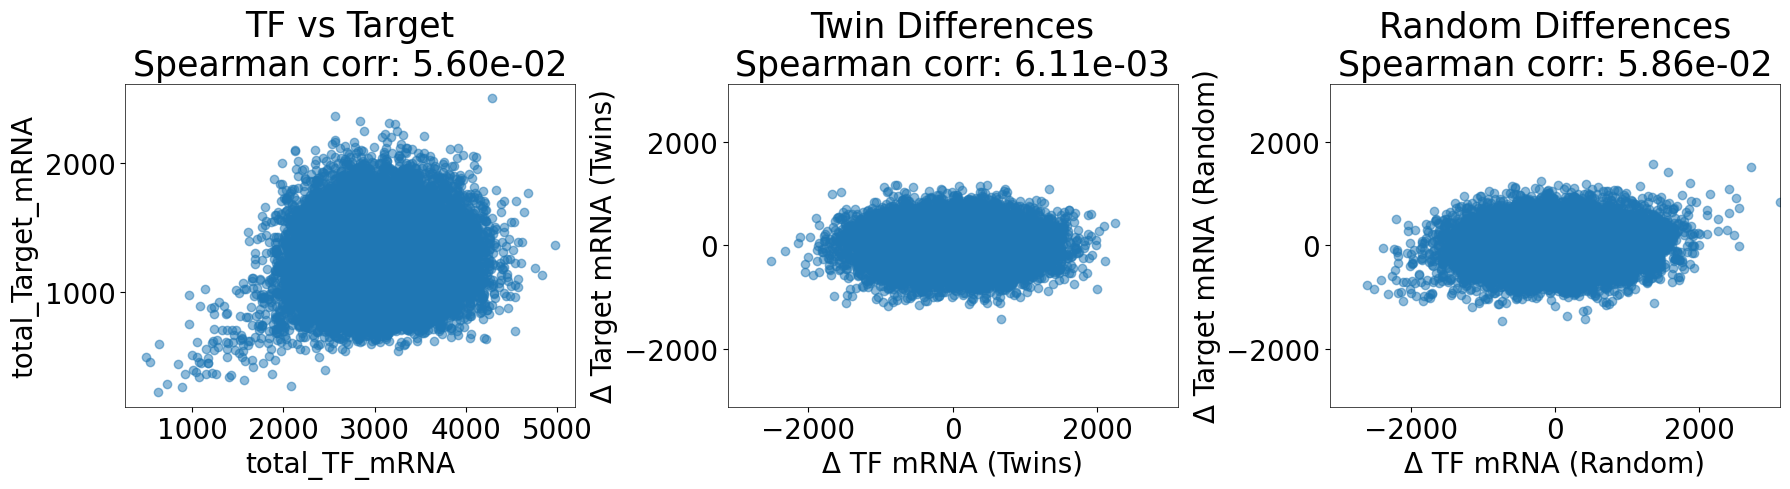

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

time = 900
singleTime_df = updated_df[updated_df['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Raw total TF vs Target mRNA ---
ax = axes[0]
total_TF = singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']
total_Target = singleTime_df['total_Target_mRNA']
corr = spearmanr(total_TF, total_Target)[0]
ax.scatter(total_TF, total_Target, alpha=0.5)
ax.set_xlabel('total_TF_mRNA')
ax.set_ylabel('total_Target_mRNA')
ax.set_title(f'TF vs Target\nSpearman corr: {corr:.2e}')

# --- 2. Twin pair differences ---
rep1 = updated_df[(updated_df['replicate'] == 0) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
rep2 = updated_df[(updated_df['replicate'] == 1) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
diff_TF = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
diff_Target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']

# --- 3. Random pair differences ---
rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
diff_TF_rand = rep1['total_TF_mRNA'] - rep2_shuffled['total_TF_mRNA']
diff_Target_rand = rep1['total_Target_mRNA'] - rep2_shuffled['total_Target_mRNA']

# --- Shared limits ---
min_val = min(diff_TF.min(), diff_Target.min(), diff_TF_rand.min(), diff_Target_rand.min())
max_val = max(diff_TF.max(), diff_Target.max(), diff_TF_rand.max(), diff_Target_rand.max())
max_num = max(abs(min_val), abs(max_val))
shared_lim = (-1*max_num, max_num)

# --- Plot twin difference ---
ax = axes[1]
corr = spearmanr(diff_TF, diff_Target)[0]
ax.scatter(diff_TF, diff_Target, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Twins)')
ax.set_ylabel('Δ Target mRNA (Twins)')
ax.set_title(f'Twin Differences\nSpearman corr: {corr:.2e}')

# --- Plot random difference ---
ax = axes[2]
corr = spearmanr(diff_TF_rand, diff_Target_rand)[0]
ax.scatter(diff_TF_rand, diff_Target_rand, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Random)')
ax.set_ylabel('Δ Target mRNA (Random)')
ax.set_title(f'Random Differences\nSpearman corr: {corr:.2e}')

# --- Finalize ---
plt.tight_layout()
plt.show()


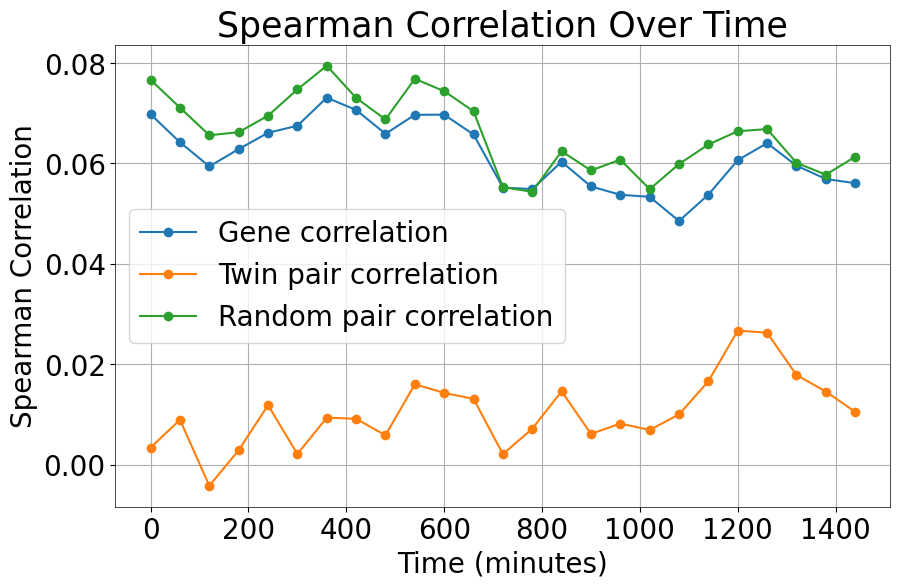

In [32]:
#Plot correlation between twin pairs at different time points
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

timePoints = np.arange(0,1441, 60)
corr_gene_list = []
corr_twin_list = []
corr_rand_list = []
for time in timePoints:
    singleTime_df = updated_df[updated_df['sampling_time'] == time]
    singleTime_df = singleTime_df.reset_index(drop=True)

    total_TF = singleTime_df['total_TF_mRNA'].values
    total_Target = singleTime_df['total_Target_mRNA'].values
    corr = spearmanr(total_TF, total_Target)[0]

    # --- 2. Twin pair differences ---
    rep1 = singleTime_df[(singleTime_df['replicate'] == 0) & (singleTime_df['sampling_time'] == time)].reset_index(drop=True)
    rep2 = singleTime_df[(singleTime_df['replicate'] == 1) & (singleTime_df['sampling_time'] == time)].reset_index(drop=True)
    diff_TF = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
    diff_Target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']

    # --- 3. Random pair differences ---
    rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
    diff_TF_rand = rep1['total_TF_mRNA'] - rep2_shuffled['total_TF_mRNA']
    diff_Target_rand = rep1['total_Target_mRNA'] - rep2_shuffled['total_Target_mRNA']
    corr_twin = spearmanr(diff_TF, diff_Target)[0]
    corr_rand = spearmanr(diff_TF_rand, diff_Target_rand)[0]
    corr_gene_list.append(corr)
    corr_twin_list.append(corr_twin)
    corr_rand_list.append(corr_rand)

# Plotting the correlations
plt.figure(figsize=(10, 6))
plt.plot(timePoints, corr_gene_list, label='Gene correlation', marker='o')
plt.plot(timePoints, corr_twin_list, label='Twin pair correlation', marker='o')
plt.plot(timePoints, corr_rand_list, label='Random pair correlation', marker='o')
plt.xlabel('Time (minutes)')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation Over Time')
plt.legend()
plt.grid()
plt.show()




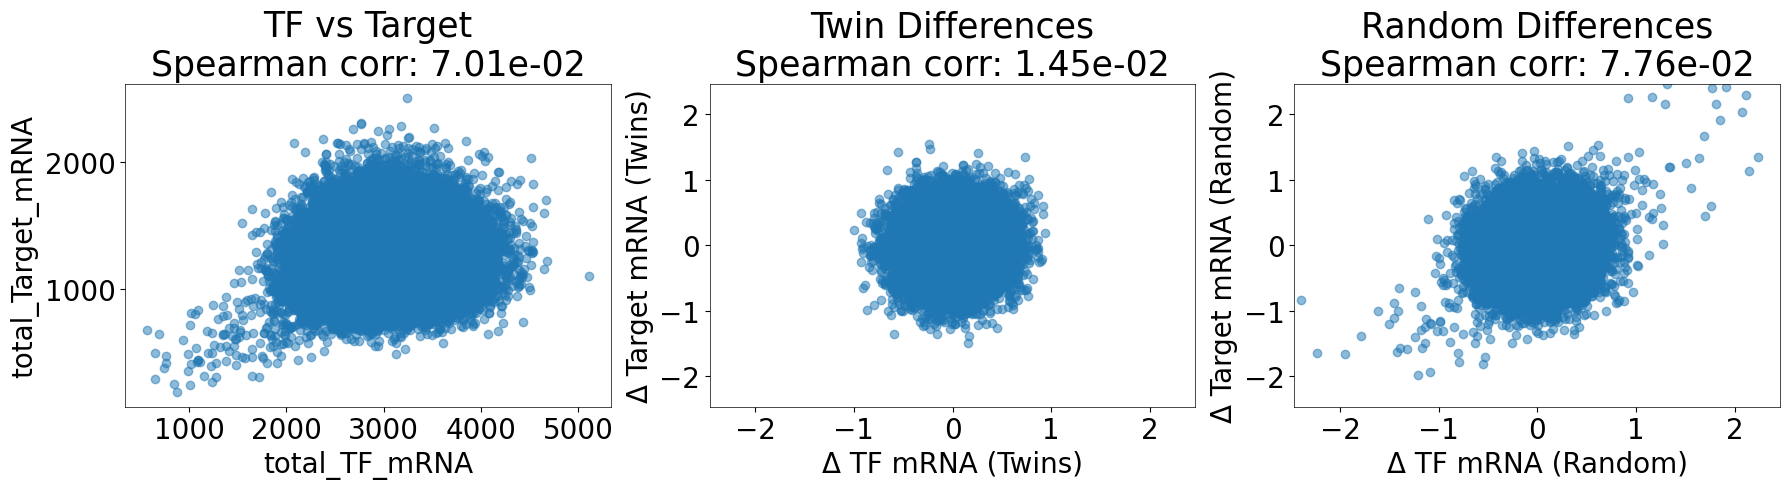

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np
#If instead of difference, plot and find correlations between log-ratios
time = 600
singleTime_df = updated_df[updated_df['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Raw total TF vs Target mRNA ---
ax = axes[0]
total_TF = singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']
total_Target = singleTime_df['total_Target_mRNA']
corr = spearmanr(total_TF, total_Target)[0]
ax.scatter(total_TF, total_Target, alpha=0.5)
ax.set_xlabel('total_TF_mRNA')
ax.set_ylabel('total_Target_mRNA')
ax.set_title(f'TF vs Target\nSpearman corr: {corr:.2e}')

# --- 2. Twin pair differences ---
rep1 = updated_df[(updated_df['replicate'] == 0) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
rep2 = updated_df[(updated_df['replicate'] == 1) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
diff_TF = np.log2(rep1['total_TF_mRNA'] + 1) - np.log2(rep2['total_TF_mRNA'] + 1)
diff_Target = np.log2(rep1['total_Target_mRNA'] + 1) -  np.log2(rep2['total_Target_mRNA'] + 1)

# --- 3. Random pair differences ---
rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
diff_TF_rand = np.log2(rep1['total_TF_mRNA'] + 1) - np.log2(1 + rep2_shuffled['total_TF_mRNA'])
diff_Target_rand = np.log2(rep1['total_Target_mRNA'] + 1) - np.log2(1 + rep2_shuffled['total_Target_mRNA'])

# --- Shared limits ---
min_val = min(diff_TF.min(), diff_Target.min(), diff_TF_rand.min(), diff_Target_rand.min())
max_val = max(diff_TF.max(), diff_Target.max(), diff_TF_rand.max(), diff_Target_rand.max())
max_num = max(abs(min_val), abs(max_val))
shared_lim = (-1*max_num, max_num)

# --- Plot twin difference ---
ax = axes[1]
corr = spearmanr(diff_TF, diff_Target)[0]
ax.scatter(diff_TF, diff_Target, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Twins)')
ax.set_ylabel('Δ Target mRNA (Twins)')
ax.set_title(f'Twin Differences\nSpearman corr: {corr:.2e}')

# --- Plot random difference ---
ax = axes[2]
corr = spearmanr(diff_TF_rand, diff_Target_rand)[0]
ax.scatter(diff_TF_rand, diff_Target_rand, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Random)')
ax.set_ylabel('Δ Target mRNA (Random)')
ax.set_title(f'Random Differences\nSpearman corr: {corr:.2e}')

# --- Finalize ---
plt.tight_layout()
plt.show()


In [5]:
#Now to compare the non-regulatory two state population
def update_df(updated_df):
    updated_df['unspliced_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['unspliced_labeled_Target']
    updated_df['unspliced_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['unspliced_labeled_TF']

    updated_df['labeled_Target'] = updated_df['unspliced_labeled_Target']+updated_df['spliced_labeled_Target']
    updated_df['labeled_TF'] = updated_df['unspliced_labeled_TF']+updated_df['spliced_labeled_TF']

    updated_df['unlabeled_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['spliced_unlabeled_Target']
    updated_df['unlabeled_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['spliced_unlabeled_TF']
    return updated_df

In [7]:
sim_file_use_pop1 = '/home/mzo5929/Keerthana/grnInference/simulationData/large_scale_parameter_scan/without_regulation/samples_replicates_without_regulation_0.csv'
sim_file_use_pop2 = '/home/mzo5929/Keerthana/grnInference/simulationData/large_scale_parameter_scan/without_regulation/samples_replicates_without_regulation_1.csv'
num_sampling_times = 24
num_cells = 20e3

updated_df_pop1 = pd.read_csv(sim_file_use_pop1)
updated_df_pop1 = update_df(updated_df_pop1)

updated_df_pop2 = pd.read_csv(sim_file_use_pop2)
updated_df_pop2 = update_df(updated_df_pop2)

In [11]:
updated_df_fin = pd.concat([updated_df_pop1, updated_df_pop2], ignore_index=True)

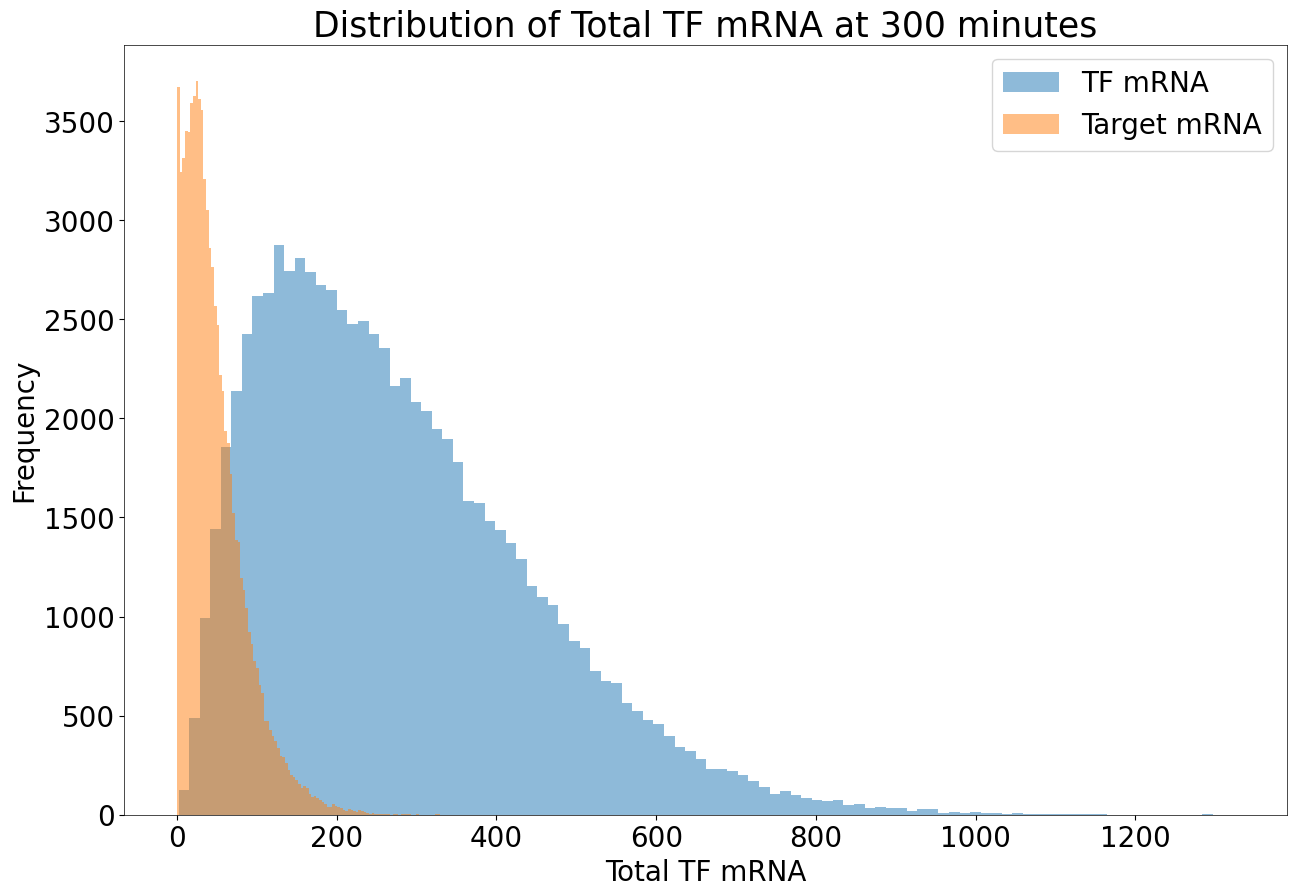

In [12]:
plt.hist(updated_df_fin[updated_df_fin['sampling_time']==300]['total_TF_mRNA'], bins=100, alpha=0.5, label='TF mRNA')
plt.hist(updated_df_fin[updated_df_fin['sampling_time']==300]['total_Target_mRNA'], bins=100, alpha=0.5, label='Target mRNA')
plt.legend(loc='upper right')
plt.xlabel('Total TF mRNA')
plt.ylabel('Frequency')
plt.title('Distribution of Total TF mRNA at 300 minutes')
plt.show()

# plt.hist(updated_df_pop1[updated_df_pop1['sampling_time']==300]['total_Target_mRNA'], bins=100, alpha=0.5, label='pop1')
# plt.hist(updated_df_pop2[updated_df_pop2['sampling_time']==300]['total_Target_mRNA'], bins=100, alpha=0.5, label='pop2')
# plt.legend(loc='upper right')
# plt.xlabel('Total Target mRNA')
# plt.ylabel('Frequency')
# plt.title('Distribution of Total Target mRNA at 300 minutes')
# plt.show()

In [ ]:
#First check for regulation within each state
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

time = 300
singleTime_df = updated_df_pop1[updated_df_pop1['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
time = 300

# --- 1. Raw total TF vs Target mRNA ---
ax = axes[0]
total_TF = singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']
total_Target = singleTime_df['total_Target_mRNA']
corr = spearmanr(total_TF, total_Target)[0]
ax.scatter(total_TF, total_Target, alpha=0.5)
ax.set_xlabel('total_TF_mRNA')
ax.set_ylabel('total_Target_mRNA')
ax.set_title(f'TF vs Target\nSpearman corr: {corr:.2f}')

# --- 2. Twin pair differences ---
rep1 = updated_df[(updated_df['replicate'] == 0) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
rep2 = updated_df[(updated_df['replicate'] == 1) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
diff_TF = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
diff_Target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']

# --- 3. Random pair differences ---
rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
diff_TF_rand = rep1['total_TF_mRNA'] - rep2_shuffled['total_TF_mRNA']
diff_Target_rand = rep1['total_Target_mRNA'] - rep2_shuffled['total_Target_mRNA']

# --- Shared limits ---
min_val = min(diff_TF.min(), diff_Target.min(), diff_TF_rand.min(), diff_Target_rand.min())
max_val = max(diff_TF.max(), diff_Target.max(), diff_TF_rand.max(), diff_Target_rand.max())
max_num = max(abs(min_val), abs(max_val))
shared_lim = (-1*max_num, max_num)

# --- Plot twin difference ---
ax = axes[1]
corr = spearmanr(diff_TF, diff_Target)[0]
ax.scatter(diff_TF, diff_Target, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Twins)')
ax.set_ylabel('Δ Target mRNA (Twins)')
ax.set_title(f'Twin Differences\nSpearman corr: {corr:.2f}')

# --- Plot random difference ---
ax = axes[2]
corr = spearmanr(diff_TF_rand, diff_Target_rand)[0]
ax.scatter(diff_TF_rand, diff_Target_rand, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Random)')
ax.set_ylabel('Δ Target mRNA (Random)')
ax.set_title(f'Random Differences\nSpearman corr: {corr:.2f}')

# --- Finalize ---
plt.tight_layout()
plt.show()


NameError: name 'updated_df' is not defined

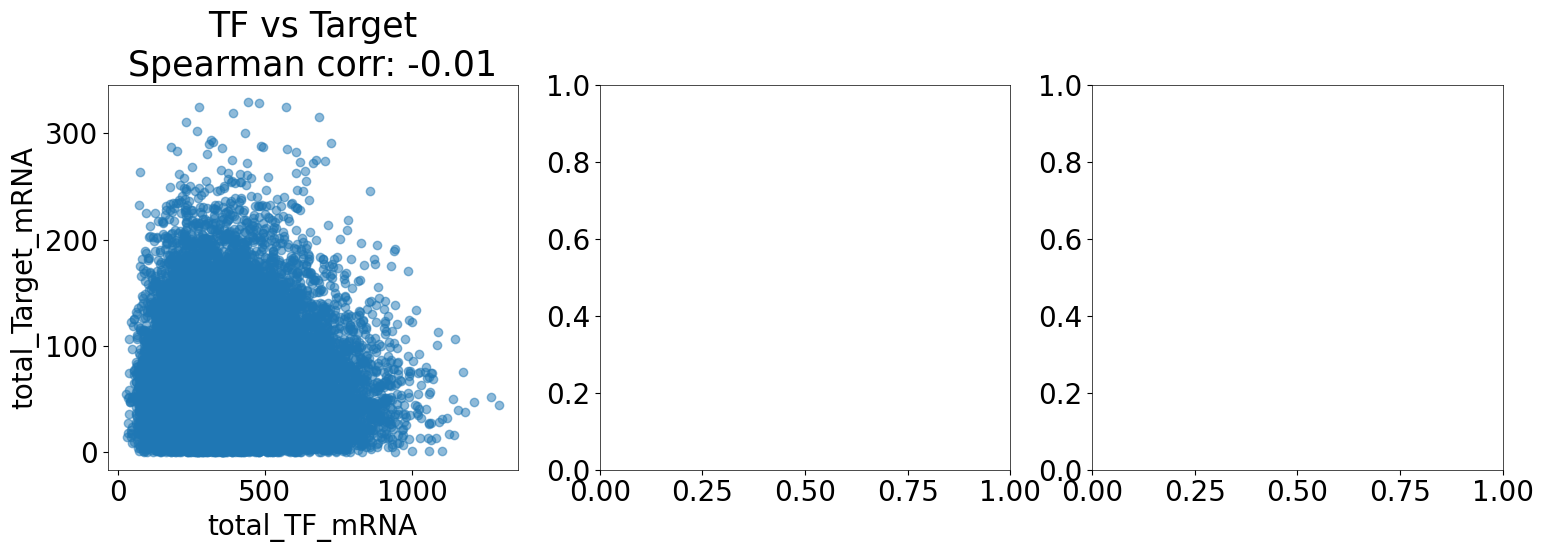

In [14]:
#First check for regulation within each state
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

time = 300
singleTime_df = updated_df_pop2[updated_df_pop2['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
time = 600

# --- 1. Raw total TF vs Target mRNA ---
ax = axes[0]
total_TF = singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']
total_Target = singleTime_df['total_Target_mRNA']
corr = spearmanr(total_TF, total_Target)[0]
ax.scatter(total_TF, total_Target, alpha=0.5)
ax.set_xlabel('total_TF_mRNA')
ax.set_ylabel('total_Target_mRNA')
ax.set_title(f'TF vs Target\nSpearman corr: {corr:.2f}')

# --- 2. Twin pair differences ---
rep1 = updated_df[(updated_df['replicate'] == 0) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
rep2 = updated_df[(updated_df['replicate'] == 1) & (updated_df['sampling_time'] == time)].reset_index(drop=True)
diff_TF = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
diff_Target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']

# --- 3. Random pair differences ---
rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
diff_TF_rand = rep1['total_TF_mRNA'] - rep2_shuffled['total_TF_mRNA']
diff_Target_rand = rep1['total_Target_mRNA'] - rep2_shuffled['total_Target_mRNA']

# --- Shared limits ---
min_val = min(diff_TF.min(), diff_Target.min(), diff_TF_rand.min(), diff_Target_rand.min())
max_val = max(diff_TF.max(), diff_Target.max(), diff_TF_rand.max(), diff_Target_rand.max())
max_num = max(abs(min_val), abs(max_val))
shared_lim = (-1*max_num, max_num)

# --- Plot twin difference ---
ax = axes[1]
corr = spearmanr(diff_TF, diff_Target)[0]
ax.scatter(diff_TF, diff_Target, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Twins)')
ax.set_ylabel('Δ Target mRNA (Twins)')
ax.set_title(f'Twin Differences\nSpearman corr: {corr:.2f}')

# --- Plot random difference ---
ax = axes[2]
corr = spearmanr(diff_TF_rand, diff_Target_rand)[0]
ax.scatter(diff_TF_rand, diff_Target_rand, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Random)')
ax.set_ylabel('Δ Target mRNA (Random)')
ax.set_title(f'Random Differences\nSpearman corr: {corr:.2f}')

# --- Finalize ---
plt.tight_layout()
plt.show()


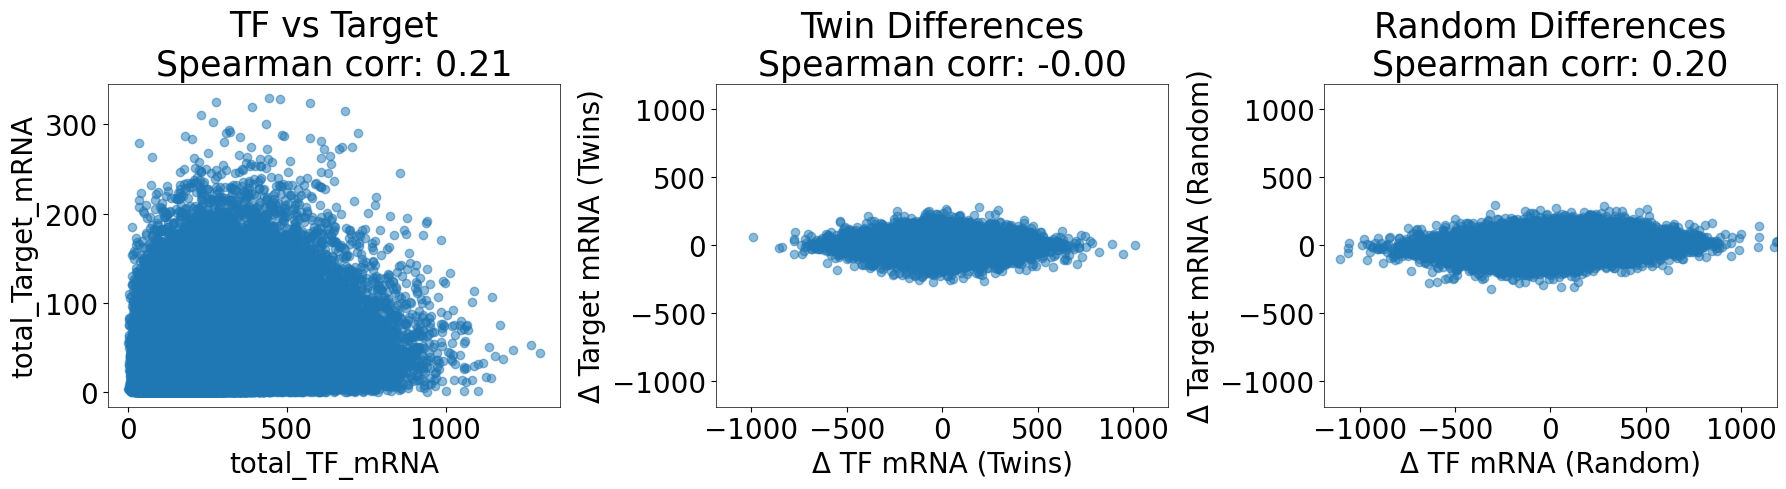

In [15]:
#First check for regulation within each state
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np
updated_df_fin = pd.concat([updated_df_pop1, updated_df_pop2], ignore_index=True)
time = 300
singleTime_df = updated_df_fin[updated_df_fin['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

# --- Plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
time = 300

# --- 1. Raw total TF vs Target mRNA ---
ax = axes[0]
total_TF = singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']
total_Target = singleTime_df['total_Target_mRNA']
corr = spearmanr(total_TF, total_Target)[0]
ax.scatter(total_TF, total_Target, alpha=0.5)
ax.set_xlabel('total_TF_mRNA')
ax.set_ylabel('total_Target_mRNA')
ax.set_title(f'TF vs Target\nSpearman corr: {corr:.2f}')

# --- 2. Twin pair differences ---
rep1 = updated_df_fin[(updated_df_fin['replicate'] == 0) & (updated_df_fin['sampling_time'] == time)].reset_index(drop=True)
rep2 = updated_df_fin[(updated_df_fin['replicate'] == 1) & (updated_df_fin['sampling_time'] == time)].reset_index(drop=True)
diff_TF = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
diff_Target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']

# --- 3. Random pair differences ---
rep2_shuffled = rep2.sample(frac=1, random_state=42).reset_index(drop=True)
diff_TF_rand = rep1['total_TF_mRNA'] - rep2_shuffled['total_TF_mRNA']
diff_Target_rand = rep1['total_Target_mRNA'] - rep2_shuffled['total_Target_mRNA']

# --- Shared limits ---
min_val = min(diff_TF.min(), diff_Target.min(), diff_TF_rand.min(), diff_Target_rand.min())
max_val = max(diff_TF.max(), diff_Target.max(), diff_TF_rand.max(), diff_Target_rand.max())
max_num = max(abs(min_val), abs(max_val))
shared_lim = (-1*max_num, max_num)

# --- Plot twin difference ---
ax = axes[1]
corr = spearmanr(diff_TF, diff_Target)[0]
ax.scatter(diff_TF, diff_Target, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Twins)')
ax.set_ylabel('Δ Target mRNA (Twins)')
ax.set_title(f'Twin Differences\nSpearman corr: {corr:.2f}')

# --- Plot random difference ---
ax = axes[2]
corr = spearmanr(diff_TF_rand, diff_Target_rand)[0]
ax.scatter(diff_TF_rand, diff_Target_rand, alpha=0.5)
ax.set_xlim(shared_lim)
ax.set_ylim(shared_lim)
ax.set_xlabel('Δ TF mRNA (Random)')
ax.set_ylabel('Δ Target mRNA (Random)')
ax.set_title(f'Random Differences\nSpearman corr: {corr:.2f}')

# --- Finalize ---
plt.tight_layout()
plt.show()


In [ ]:
#Plot the regulatory and non-regulatory state for all 3: gene vs gene, twin, random
time = 300

#For the regulatory state
regulated_simulation_csv = '/home/mzo5929/Keerthana/grnInference/simulationData/large_scale_parameter_scan/regulation/samples_replicates_regulation_14263.csv'
regulated_simulation = pd.read_csv(regulated_simulation_csv)
regulated_simulation = update_df(regulated_simulation)
singleTime_df_regulated = regulated_simulation[regulated_simulation['sampling_time'] == time]
singleTime_df_regulated = singleTime_df_regulated.reset_index(drop=True)

#Twin and random calculations 
rep1_reg = singleTime_df_regulated[(singleTime_df_regulated['replicate'] == 0)].reset_index(drop=True)
rep2_reg = singleTime_df_regulated[(singleTime_df_regulated['replicate'] == 1)].reset_index(drop=True)
rep2_reg_random = rep2_reg.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_reg_twin = rep1_reg['total_TF_mRNA'] - rep2_reg['total_TF_mRNA']
diff_Target_reg_twin = rep1_reg['total_Target_mRNA'] - rep2_reg['total_Target_mRNA']
diff_TF_reg_random = rep1_reg['total_TF_mRNA'] - rep2_reg_random['total_TF_mRNA']
diff_Target_reg_random = rep1_reg['total_Target_mRNA'] - rep2_reg_random['total_Target_mRNA']


#For the one state non-regulatory 
non_regulatory_simulation_csv_1 = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_quartile_params/samples_replicates_over_time_with_regulation_lower_quartile_0.csv'
non_regulatory_simulation_1 = pd.read_csv(non_regulatory_simulation_csv_1)
non_regulatory_simulation_1 = update_df(non_regulatory_simulation_1)
singleTime_df_non_regulatory_1 = non_regulatory_simulation_1[non_regulatory_simulation_1['sampling_time'] == time]
singleTime_df_non_regulatory_1 = singleTime_df_non_regulatory_1.reset_index(drop=True)

#Twin and random calculations
rep1_non_reg_1 = singleTime_df_non_regulatory_1[(singleTime_df_non_regulatory_1['replicate'] == 0)].reset_index(drop=True)
rep2_non_reg_1 = singleTime_df_non_regulatory_1[(singleTime_df_non_regulatory_1['replicate'] == 1)].reset_index(drop=True)
rep2_non_reg_1_random = rep2_non_reg_1.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_non_reg_1_twin = rep1_non_reg_1['total_TF_mRNA'] - rep2_non_reg_1['total_TF_mRNA']
diff_Target_non_reg_1_twin = rep1_non_reg_1['total_Target_mRNA'] - rep2_non_reg_1['total_Target_mRNA']
diff_TF_non_reg_1_random = rep1_non_reg_1['total_TF_mRNA'] - rep2_non_reg_1_random['total_TF_mRNA']
diff_Target_non_reg_1_random = rep1_non_reg_1['total_Target_mRNA'] - rep2_non_reg_1_random['total_Target_mRNA']


#For the other one state non-regulatory 
non_regulatory_simulation_csv_2 = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_quartile_params/samples_replicates_over_time_with_regulation_upper_quartile_0.csv'
non_regulatory_simulation_2 = pd.read_csv(non_regulatory_simulation_csv_2)
non_regulatory_simulation_2 = update_df(non_regulatory_simulation_2)
singleTime_df_non_regulatory_2 = non_regulatory_simulation_2[non_regulatory_simulation_2['sampling_time'] == time]
singleTime_df_non_regulatory_2 = singleTime_df_non_regulatory_2.reset_index(drop=True)

#Twin and random calculations
rep1_non_reg_2 = singleTime_df_non_regulatory_2[(singleTime_df_non_regulatory_2['replicate'] == 0)].reset_index(drop=True)
rep2_non_reg_2 = singleTime_df_non_regulatory_2[(singleTime_df_non_regulatory_2['replicate'] == 1)].reset_index(drop=True)
rep2_non_reg_2_random = rep2_non_reg_2.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_non_reg_2_twin = rep1_non_reg_2['total_TF_mRNA'] - rep2_non_reg_2['total_TF_mRNA']
diff_Target_non_reg_2_twin = rep1_non_reg_2['total_Target_mRNA'] - rep2_non_reg_2['total_Target_mRNA']
diff_TF_non_reg_2_random = rep1_non_reg_2['total_TF_mRNA'] - rep2_non_reg_2_random['total_TF_mRNA']
diff_Target_non_reg_2_random = rep1_non_reg_2['total_Target_mRNA'] - rep2_non_reg_2_random['total_Target_mRNA']

#For the two state non-regulatory 
non_regulatory_simulation_2state = pd.concat([non_regulatory_simulation_1, non_regulatory_simulation_2], ignore_index=True)
singleTime_df_non_regulatory_2state = non_regulatory_simulation_2state[non_regulatory_simulation_2state['sampling_time'] == time]
singleTime_df_non_regulatory_2state = singleTime_df_non_regulatory_2state.reset_index(drop=True)

#Twin and random calculations
rep1_non_reg_2state = singleTime_df_non_regulatory_2state[(singleTime_df_non_regulatory_2state['replicate'] == 0)].reset_index(drop=True)
rep2_non_reg_2state = singleTime_df_non_regulatory_2state[(singleTime_df_non_regulatory_2state['replicate'] == 1)].reset_index(drop=True)
rep2_non_reg_2state_random = rep2_non_reg_2state.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_non_reg_2state_twin = rep1_non_reg_2state['total_TF_mRNA'] - rep2_non_reg_2state['total_TF_mRNA']
diff_Target_non_reg_2state_twin = rep1_non_reg_2state['total_Target_mRNA'] - rep2_non_reg_2state['total_Target_mRNA']
diff_TF_non_reg_2state_random = rep1_non_reg_2state['total_TF_mRNA'] - rep2_non_reg_2state_random['total_TF_mRNA']
diff_Target_non_reg_2state_random = rep1_non_reg_2state['total_Target_mRNA'] - rep2_non_reg_2state_random['total_Target_mRNA']

#Plot the regulatory and non-regulatory state for all 3: gene vs gene, twin, random with common axes limits across all plots

#Calculate shared limits
min_val_diff = min(diff_TF_reg_twin.min(), diff_Target_reg_twin.min(), diff_TF_reg_random.min(), diff_Target_reg_random.min(),
              diff_TF_non_reg_1_twin.min(), diff_Target_non_reg_1_twin.min(), diff_TF_non_reg_1_random.min(), diff_Target_non_reg_1_random.min(),
              diff_TF_non_reg_2_twin.min(), diff_Target_non_reg_2_twin.min(), diff_TF_non_reg_2_random.min(), diff_Target_non_reg_2_random.min(),
              diff_TF_non_reg_2state_twin.min(), diff_Target_non_reg_2state_twin.min(), diff_TF_non_reg_2state_random.min(), diff_Target_non_reg_2state_random.min())

max_val_diff = max(diff_TF_reg_twin.max(), diff_Target_reg_twin.max(), diff_TF_reg_random.max(), diff_Target_reg_random.max(),
              diff_TF_non_reg_1_twin.max(), diff_Target_non_reg_1_twin.max(), diff_TF_non_reg_1_random.max(), diff_Target_non_reg_1_random.max(),
              diff_TF_non_reg_2_twin.max(), diff_Target_non_reg_2_twin.max(), diff_TF_non_reg_2_random.max(), diff_Target_non_reg_2_random.max(),
              diff_TF_non_reg_2state_twin.max(), diff_Target_non_reg_2state_twin.max(), diff_TF_non_reg_2state_random.max(), diff_Target_non_reg_2state_random.max())

min_val_counts = min(singleTime_df_regulated['total_TF_mRNA'].min(), singleTime_df_regulated['total_Target_mRNA'].min(), singleTime_df_non_regulatory_1['total_TF_mRNA'].min(), singleTime_df_non_regulatory_1['total_Target_mRNA'].min(),
                singleTime_df_non_regulatory_2['total_TF_mRNA'].min(), singleTime_df_non_regulatory_2['total_Target_mRNA'].min(), singleTime_df_non_regulatory_2state['total_TF_mRNA'].min(), singleTime_df_non_regulatory_2state['total_Target_mRNA'].min())

max_val_counts = max(singleTime_df_regulated['total_TF_mRNA'].max(), singleTime_df_regulated['total_Target_mRNA'].max(), singleTime_df_non_regulatory_1['total_TF_mRNA'].max(), singleTime_df_non_regulatory_1['total_Target_mRNA'].max(),
                singleTime_df_non_regulatory_2['total_TF_mRNA'].max(), singleTime_df_non_regulatory_2['total_Target_mRNA'].max(), singleTime_df_non_regulatory_2state['total_TF_mRNA'].max(), singleTime_df_non_regulatory_2state['total_Target_mRNA'].max())

max_num_diff = max(abs(min_val_diff), abs(max_val_diff))
max_num_counts = max(abs(min_val_counts), abs(max_val_counts))
shared_lim_diff = (-1*max_num_diff, max_num_diff)
shared_lim_counts = (0, max_num_counts)

In [ ]:
shared_lim_diff

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Create main figure and 4 vertically stacked subfigures ---
fig = plt.figure(figsize=(18, 20), constrained_layout=True)
subfigs = fig.subfigures(4, 1, height_ratios=[1, 1, 1, 1])
titles = [
    "Regulated (1-state)",
    "Non-regulated (1-state A)",
    "Non-regulated (1-state B)",
    "Non-regulated (2-state)"
]

def plot_subplot_set(axes, x_vals, y_vals, dx_twin, dy_twin, dx_rand, dy_rand, count_lim, diff_lim):
    # Panel 1: TF vs Target
    axes[0].scatter(x_vals, y_vals, alpha=0.5)
    corr = spearmanr(x_vals, y_vals)[0]
    axes[0].set_xlabel(r'TF mRNA')
    axes[0].set_ylabel(r'Target mRNA')
    axes[0].set_xlim(count_lim)
    axes[0].set_ylim(count_lim)
    axes[0].set_title(rf'$\mathrm{{TF\ vs\ Target}} \quad (\rho = {corr:.2e})$')


    # Panel 2: Twin Differences
    axes[1].scatter(dx_twin, dy_twin, alpha=0.5)
    corr = spearmanr(dx_twin, dy_twin)[0]
    axes[1].set_xlabel(r'$\Delta$ TF mRNA (Twins)')
    axes[1].set_ylabel(r'$\Delta$ Target mRNA (Twins)')
    axes[1].set_xlim(diff_lim)
    axes[1].set_ylim(diff_lim)

    axes[1].set_title(rf'$\mathrm{{Twin Differences}} \quad (\bar{{\rho}}^\Delta = {corr:.2e})$')

    # Panel 3: Random Differences
    axes[2].scatter(dx_rand, dy_rand, alpha=0.5)
    corr = spearmanr(dx_rand, dy_rand)[0]
    axes[2].set_xlabel(r'$\Delta$ TF mRNA (Random)')
    axes[2].set_ylabel(r'$\Delta$ Target mRNA (Random)')
    axes[2].set_xlim(diff_lim)
    axes[2].set_ylim(diff_lim)
    axes[2].set_title(rf'$\mathrm{{Random Differences}} \quad (\rho^\Delta = {corr:.2e})$')

# ---------------------------- Regulated ----------------------------
subfig = subfigs[0]
subfig.suptitle(titles[0], fontsize=14, weight='bold')
axes = subfig.subplots(1, 3)
plot_subplot_set(
    axes,
    singleTime_df_regulated['total_TF_mRNA'], singleTime_df_regulated['total_Target_mRNA'],
    diff_TF_reg_twin, diff_Target_reg_twin,
    diff_TF_reg_random, diff_Target_reg_random,
    shared_lim_counts, shared_lim_diff
)

# ---------------------------- Non-regulated A ----------------------------
subfig = subfigs[1]
subfig.suptitle(titles[1], fontsize=14, weight='bold')
axes = subfig.subplots(1, 3)
plot_subplot_set(
    axes,
    singleTime_df_non_regulatory_1['total_TF_mRNA'], singleTime_df_non_regulatory_1['total_Target_mRNA'],
    diff_TF_non_reg_1_twin, diff_Target_non_reg_1_twin,
    diff_TF_non_reg_1_random, diff_Target_non_reg_1_random,
    shared_lim_counts, shared_lim_diff
)

# ---------------------------- Non-regulated B ----------------------------
subfig = subfigs[2]
subfig.suptitle(titles[2], fontsize=14, weight='bold')
axes = subfig.subplots(1, 3)
plot_subplot_set(
    axes,
    singleTime_df_non_regulatory_2['total_TF_mRNA'], singleTime_df_non_regulatory_2['total_Target_mRNA'],
    diff_TF_non_reg_2_twin, diff_Target_non_reg_2_twin,
    diff_TF_non_reg_2_random, diff_Target_non_reg_2_random,
    shared_lim_counts, shared_lim_diff
)

# ---------------------------- Non-regulated 2-state ----------------------------
subfig = subfigs[3]
subfig.suptitle(titles[3], fontsize=14, weight='bold')
axes = subfig.subplots(1, 3)
plot_subplot_set(
    axes,
    singleTime_df_non_regulatory_2state['total_TF_mRNA'], singleTime_df_non_regulatory_2state['total_Target_mRNA'],
    diff_TF_non_reg_2state_twin, diff_Target_non_reg_2state_twin,
    diff_TF_non_reg_2state_random, diff_Target_non_reg_2state_random,
    shared_lim_counts, shared_lim_diff
)

plt.show()


In [ ]:
#Regress out state from counts - what happens then?

#Twin and random calculations
rep1_non_reg_2 = singleTime_df_non_regulatory_2[(singleTime_df_non_regulatory_2['replicate'] == 0)].reset_index(drop=True)
rep2_non_reg_2 = singleTime_df_non_regulatory_2[(singleTime_df_non_regulatory_2['replicate'] == 1)].reset_index(drop=True)
rep2_non_reg_2_random = rep2_non_reg_2.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_non_reg_2_twin = rep1_non_reg_2['total_TF_mRNA'] - rep2_non_reg_2['total_TF_mRNA']
diff_Target_non_reg_2_twin = rep1_non_reg_2['total_Target_mRNA'] - rep2_non_reg_2['total_Target_mRNA']
diff_TF_non_reg_2_random = rep1_non_reg_2['total_TF_mRNA'] - rep2_non_reg_2_random['total_TF_mRNA']
diff_Target_non_reg_2_random = rep1_non_reg_2['total_Target_mRNA'] - rep2_non_reg_2_random['total_Target_mRNA']

#For the two state non-regulatory 
non_regulatory_simulation_1['state'] = 'high'
non_regulatory_simulation_2['state'] = 'low'
non_regulatory_simulation_2state = pd.concat([non_regulatory_simulation_1, non_regulatory_simulation_2], ignore_index=True)
singleTime_df_non_regulatory_2state = non_regulatory_simulation_2state[non_regulatory_simulation_2state['sampling_time'] == time]

#Regress out state from counts
singleTime_df_non_regulatory_2state = singleTime_df_non_regulatory_2state.reset_index(drop=True)
singleTime_df_non_regulatory_2state['total_TF_mRNA'] = singleTime_df_non_regulatory_2state['total_TF_mRNA'] - singleTime_df_non_regulatory_2state['state'].map({'high': 1, 'low': 0})

#Twin and random calculations
rep1_non_reg_2state = singleTime_df_non_regulatory_2state[(singleTime_df_non_regulatory_2state['replicate'] == 0)].reset_index(drop=True)
rep2_non_reg_2state = singleTime_df_non_regulatory_2state[(singleTime_df_non_regulatory_2state['replicate'] == 1)].reset_index(drop=True)
rep2_non_reg_2state_random = rep2_non_reg_2state.sample(frac=1, random_state=42).reset_index(drop=True)

diff_TF_non_reg_2state_twin = rep1_non_reg_2state['total_TF_mRNA'] - rep2_non_reg_2state['total_TF_mRNA']
diff_Target_non_reg_2state_twin = rep1_non_reg_2state['total_Target_mRNA'] - rep2_non_reg_2state['total_Target_mRNA']
diff_TF_non_reg_2state_random = rep1_non_reg_2state['total_TF_mRNA'] - rep2_non_reg_2state_random['total_TF_mRNA']
diff_Target_non_reg_2state_random = rep1_non_reg_2state['total_Target_mRNA'] - rep2_non_reg_2state_random['total_Target_mRNA']

#
